In [1]:
##Calculated MSE, Cross Validation Test, Regression Model Validation, Normalize with Categoricals

In [1]:
##Calculated MSE, Cross Validation Test, Regression Model Validation, Normalize with Categoricals

In [2]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
from sklearn.preprocessing import OneHotEncoder
from statsmodels.formula.api import ols
%matplotlib inline

df = pd.read_csv('data\\kc_house_data.csv')
#refined dataset to drop unnecessary column data
df.drop(['id', 'date', 'waterfront', 'sqft_above', 'sqft_basement', 'lat', 'long', 'view', 'sqft_living15', 'sqft_lot15', 'waterfront', 'yr_renovated'], axis=1, inplace=True)
#incorporated lamda to reduce exponential value occurence
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if int(x) == x else '{:,.2f}'.format(x) 

In [3]:
#create the column data
continuous = ['price', 'bedrooms', 'bathrooms', 'grade']
categoricals = ['sqft_living', 'sqft_lot', 'yr_built', 'zipcode', 'floors', 'condition']
df_cont = df[continuous]

In [4]:
# log features
log_names = [f'{column}_log' for column in df_cont.columns]
df_log = np.log(df_cont)
df_log.columns = log_names

In [5]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,zipcode
count,21597,21597,21597,21597,21597,21597,21597,21597,21597,21597
mean,"540,296.57",3.37,2.12,"2,080.32","15,099.41",1.49,3.41,7.66,"1,971.00","98,077.95"
std,"367,368.14",0.93,0.77,918.11,"41,412.64",0.54,0.65,1.17,29.38,53.51
min,78000,1,0.50,370,520,1,1,3,1900,98001
25%,322000,3,1.75,1430,5040,1,3,7,1951,98033
50%,450000,3,2.25,1910,7618,1.50,3,7,1975,98065
75%,645000,4,2.50,2550,10685,2,4,8,1997,98118
max,7700000,33,8,13540,1651359,3.50,5,13,2015,98199


In [6]:
# normalize (subract mean and divide by std)
def normalize(feature):
    return (feature - feature.mean()) / feature.std()
df_log_norm = df_log.apply(normalize)

In [7]:
# one hot encode categoricals
df_ohe = pd.get_dummies(df[categoricals], prefix=categoricals[0], drop_first=True)
preprocessed = pd.concat([df_log_norm, df_ohe], axis=1)
X = preprocessed.drop('sqft_living', axis=1)
y = preprocessed['sqft_living']

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# Split the data into training and test sets (assign 20% to test set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [10]:
# A brief preview of train-test split
print(len(X_train), len(X_test), len(y_train), len(y_test))

17277 4320 17277 4320


In [11]:
#apply model to the train set 
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_hat_test = linreg.predict(X_test)

In [12]:
#calculate training and test MSE
from sklearn.metrics import mean_squared_error
test_residuals = y_hat_test - y_test
test_mse = mean_squared_error(y_test, y_hat_test)
test_mse

249060.48086378496

In [13]:
def kfolds(data, k):
    # Force data as pandas DataFrame
    data = pd.DataFrame(data)
    num_observations = len(data)
    fold_size = num_observations//k
    leftovers = num_observations%k
    folds = []
    start_obs = 0
    for fold_n in range(1,k+1):
        if fold_n <= leftovers:
            #Fold Size will be 1 larger to account for leftovers
            fold =  data.iloc[start_obs : start_obs+fold_size+1] 
            folds.append(fold)
            start_obs +=  fold_size + 1
        else:
            fold =  data.iloc[start_obs : start_obs+fold_size] 
            folds.append(fold)
            start_obs +=  fold_size          
    return folds 

In [14]:
df_data = pd.concat([X.reset_index(drop=True), y], axis=1)


In [15]:
df_folds = kfolds(df_data, 5)

In [16]:
test_errs = []
train_errs = []
k=5
for n in range(k):
    # Split in train and test for the fold
    train = pd.concat([fold for i, fold in enumerate(df_folds) if i!=n])
    test = df_folds[n]
    # Fit a linear regression model
    linreg.fit(X_train, y_train)
    #Evaluate Train and Test Errors
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_residuals = y_hat_train - y_train
    test_residuals = y_hat_test - y_test
    train_errs.append(np.mean(train_residuals.astype(float)**2))
    test_errs.append(np.mean(test_residuals.astype(float)**2))
print(train_errs)
print(test_errs)

[216855.35001900673, 216855.35001900673, 216855.35001900673, 216855.35001900673, 216855.35001900673]
[249060.48086378459, 249060.48086378459, 249060.48086378459, 249060.48086378459, 249060.48086378459]


In [17]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
mse = make_scorer(mean_squared_error)
cv_5_results = cross_val_score(linreg, X, y, cv=5, scoring=mse)

In [18]:
cv_5_results.mean()

226852.97450995035

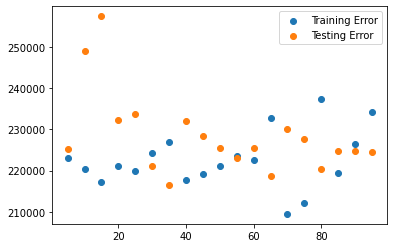

In [19]:
import random
random.seed(110)

train_err = []
test_err = []
t_sizes = list(range(5,100,5))
for t_size in t_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend()

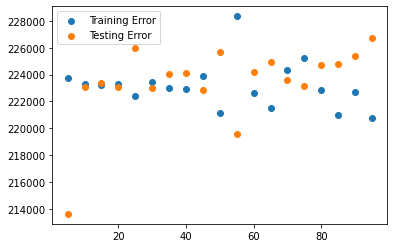

In [20]:
# Your code here
random.seed(900)

train_err = []
test_err = []
t_sizes = range(5,100,5)
for t_size in t_sizes:
    temp_train_err = []
    temp_test_err = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
        linreg.fit(X_train, y_train)
        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)
        temp_train_err.append(mean_squared_error(y_train, y_hat_train))
        temp_test_err.append(mean_squared_error(y_test, y_hat_test))
    train_err.append(np.mean(temp_train_err))
    test_err.append(np.mean(temp_test_err))
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend()